In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns             # visualizations
import matplotlib.pyplot as plt   # visualizations
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

## Uploading data

In [6]:
df = pd.read_csv('../Dataset/cardio_train.csv', sep=";")

In [7]:
dfcol=df.columns
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Checking if the targets are balanced

<AxesSubplot:xlabel='cardio', ylabel='count'>

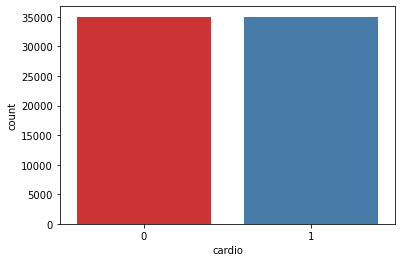

In [8]:
df[["cardio","height"]].groupby("cardio").count()
sns.countplot(x="cardio", data=df, palette="Set1")

## Data Transform (Scaling to avoid outliers)


In [9]:
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
dfscale=scaler.fit_transform(df)
dfscale2=pd.DataFrame(dfscale, columns=dfcol)
dfscale2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0.00000,0.588076,1.0,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,0.0,1.0,0.0
1,0.00001,0.730159,0.0,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,0.0,1.0,1.0
2,0.00002,0.624003,0.0,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0,0.0,1.0
3,0.00003,0.528455,1.0,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,0.0,1.0,1.0
4,0.00004,0.516918,0.0,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting data


In [10]:
xdf=dfscale2.iloc[:,0:11]
ydf=dfscale2.iloc[:,-1]

In [11]:
x_training, x_testing, y_training, y_testing = train_test_split(xdf, ydf, test_size = 0.2, random_state=123, stratify=ydf)

In [12]:
print(xdf.shape)

(70000, 11)


In [13]:
ydf.shape

(70000,)

## Neural Network


In [14]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.constraints import maxnorm

model = Sequential()
model.add(Dense(25, input_dim=11, activation='softsign', kernel_constraint=maxnorm(2)))
#model.add(Dropout(0))
model.add(Dense(5, activation='softsign'))
#model.add(Dropout(0))
model.add(Dense(3, activation='softsign'))
#model.add(Dropout(0))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 130       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(x_training, y_training, epochs=50, batch_size=50, verbose=0)
score = model.evaluate(x_training, y_training)
print("\n Training Accuracy:", score[1])
score = model.evaluate(x_testing, y_testing)
print("\n Testing Accuracy:", score[1])

1750/1750 [==============================] - 1s 357us/step - loss: 0.5715 - accuracy: 0.7081

 Training Accuracy: 0.708089292049408
438/438 [==============================] - 0s 683us/step - loss: 0.5721 - accuracy: 0.7112

 Testing Accuracy: 0.7112143039703369


## Prediction

<ipython-input-16-8212ae7d1109>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictionarray=prediction.astype(np.float)
C:\Users\Aditya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pr', ylabel='Density'>

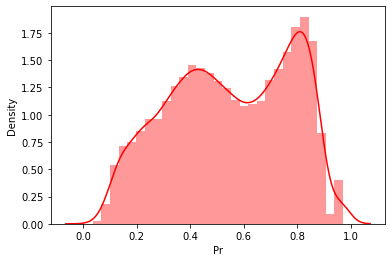

In [16]:
res=model.predict(x_testing)
res
resdf=pd.DataFrame(res, index=x_testing.index)
resdf.columns=["Pr"]
resdf["ID"]=range(14000)
resdf["y"]=np.where(resdf["Pr"]>=0.5,"1", "0")
resdf
prediction=resdf.drop(["Pr","ID"], axis=1)
predictionarray=prediction.astype(np.float)
sns.distplot(resdf["Pr"],  color="red")

#### How many 1's and 0's predict the model


In [17]:
c1=resdf[['ID','y']].groupby('y').count()
c1

,ID
y,
0,6107
1,7893


#### How many 1's and 0's are in the test sample


In [18]:
y_testingdf=pd.DataFrame(y_testing, index=y_testing.index)
y_testingdf["ID"]=range(14000)
y_test=y_testingdf.drop(["ID"], axis=1)
c2=y_testingdf[['ID','cardio']].groupby('cardio').count()
c2

,ID
cardio,
0.0,7004
1.0,6996


## Confusion Matrix


In [19]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.values, predictionarray)
cm

array([[4534, 2470],
       [1573, 5423]], dtype=int64)

### Accuracy of the Model

In [20]:
Accuracy=cm[0,0]/(cm[0,0]+cm[1,0])
print("The accuracy of the model is: "+ str(Accuracy*100) + " %")

The accuracy of the model is: 74.24267234321272 %


## Predicting a single case

In [26]:
#INSERT DATA#
###############################################################################

day= 25 # day of bith 
month= 9 # month of bith (in numbers)
year= 1968 # year of bith
gender= 1 # 0 for women, 1 for men
height= 183 # in cm
weight= 80 # in kilograms
systolicbloodpressure= 120 # Systolic blood pressure
diastolicbloodpressure= 100 # Diastolic blood pressure
cholesterol= 3 # 1: normal, 2: above normal, 3: well above normal
gluc= 3 # 1: normal, 2: above normal, 3: well above normal
smoke= 0 # 1 if you smoke, 0 if not
alco= 0 # 1 if you drink alcohol, 0 if not
active= 1 # 1 if you do physical activity, 0 if not

##############################################################################
from datetime import date
f_date = date(year,month,day)
l_date = date.today()
delta = l_date - f_date
agedays=delta.days

agedayscale=(agedays-df["age"].min())/(df["age"].max()-df["age"].min())
heightscale=(height-df["height"].min())/(df["height"].max()-df["height"].min())
weightscale=(weight-df["weight"].min())/(df["weight"].max()-df["weight"].min())
sbpscale=(systolicbloodpressure-df["ap_hi"].min())/(df["ap_hi"].max()-df["ap_hi"].min())
dbpscale=(diastolicbloodpressure-df["ap_lo"].min())/(df["ap_lo"].max()-df["ap_lo"].min())
cholesterolscale=(cholesterol-df["cholesterol"].min())/(df["cholesterol"].max()-df["cholesterol"].min())
glucscale=(gluc-df["gluc"].min())/(df["gluc"].max()-df["gluc"].min())

single=np.array([agedayscale, gender, heightscale, weightscale, sbpscale, dbpscale, cholesterolscale, glucscale, smoke, alco, active ])
singledf=pd.DataFrame(single)
final=singledf.transpose()
final

,0,1,2,3,4,5,6,7,8,9,10
0,0.707704,1.0,0.65641,0.368421,0.016698,0.015357,1.0,1.0,0.0,0.0,1.0


In [27]:
finalres=model.predict(final) 
print("The probability of having or to have a Cardiovascular Disease is: "+ str(round(finalres[0,0]*100,2)) + "%")

The probability of having or to have a Cardiovascular Disease is: 97.17%


In [23]:
from keras.models import model_from_json

model.save_weights("weights.hdf5")
json_string = model.to_json()
modeltopredict = model_from_json(json_string)
modeltopredict.load_weights("weights.hdf5", by_name=False)

prediction=modeltopredict.predict(final)

if prediction[0,0]>=0.5:
    print("The probability of having or to have a Cardiovascular Disease is: "+ str(round(prediction[0,0]*100,2)) + "%")
    print("You must visit a doctor to check it :(")
elif prediction[0,0]<0.5 and prediction[0,0]>=0.3:
    print("The probability of having or to have a Cardiovascular Disease is: "+ str(round(prediction[0,0]*100,2)) + "%")
    print("Probably you are healthy :/ ")
else:
    print("The probability of having or to have a Cardiovascular Disease is: "+ str(round(prediction[0,0]*100,2)) + "%")
    print("You are healthy :) ")

The probability of having or to have a Cardiovascular Disease is: 5.81%
You are healthy :) 


## Tuning hyperparameters to look up for the best NN

In [20]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

### Batch Size and Epochs

In [21]:
def create_model(): 
    model = Sequential() 
    model.add(Dense(10, input_dim=11, activation='tanh')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(5, activation='relu')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(3, activation='relu')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss = 'binary_crossentropy', optimizer='sgd', metrics=['accuracy']) 
    return model

In [22]:
# create model 

model = KerasClassifier(build_fn=create_model, verbose=0)

In [23]:
# params

batch_size = [10, 50, 100] 
epochs = [10, 50, 100] 
param_grid = dict(batch_size=batch_size, epochs=epochs) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) 
grid_result = grid.fit(x_training, y_training)

In [24]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params'] 
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.643536 using {'batch_size': 10, 'epochs': 100}
0.638107 (0.002593) with: {'batch_size': 10, 'epochs': 10}
0.642357 (0.004688) with: {'batch_size': 10, 'epochs': 50}
0.643536 (0.005602) with: {'batch_size': 10, 'epochs': 100}
0.626286 (0.011376) with: {'batch_size': 50, 'epochs': 10}
0.640000 (0.003465) with: {'batch_size': 50, 'epochs': 50}
0.641054 (0.004784) with: {'batch_size': 50, 'epochs': 100}
0.592696 (0.028729) with: {'batch_size': 100, 'epochs': 10}
0.634571 (0.007824) with: {'batch_size': 100, 'epochs': 50}
0.640875 (0.004423) with: {'batch_size': 100, 'epochs': 100}


## Optimization Algorithm

In [25]:
# function to create model

def create_model(optimizer='adam'): 
    model = Sequential() 
    model.add(Dense(10, input_dim=11, activation='tanh')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(5, activation='relu')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(3, activation='relu')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model

In [26]:
# create model

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

In [27]:
# define the parameters to search in grid search

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] 
param_grid = dict(optimizer=optimizer) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) 
grid_result = grid.fit(x_training, y_training)

In [28]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params'] 
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.712482 using {'optimizer': 'Nadam'}
0.639286 (0.007293) with: {'optimizer': 'SGD'}
0.690536 (0.007933) with: {'optimizer': 'RMSprop'}
0.579446 (0.023011) with: {'optimizer': 'Adagrad'}
0.527214 (0.027126) with: {'optimizer': 'Adadelta'}
0.699946 (0.011432) with: {'optimizer': 'Adam'}
0.646268 (0.003306) with: {'optimizer': 'Adamax'}
0.712482 (0.007394) with: {'optimizer': 'Nadam'}


## Optimization of SGD algorithm (Learnig Rate and Momentum)

In [29]:
# function to create model

def create_model(learn_rate=0.01, momentum=0): 
    model = Sequential() 
    model.add(Dense(10, input_dim=11, activation='tanh')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(5, activation='relu')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(3, activation='relu')) 
    model.add(Dropout(0.1)) 
    model.add(Dense(1, activation='sigmoid')) 
    optimizer = SGD(lr=learn_rate, momentum=momentum) 
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model

In [30]:
# create model

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

In [32]:
# define the parameters to search in grid search

learn_rate = [0.01, 0.1, 0.2] 
momentum = [0.2, 0.6, 0.9] 
param_grid = dict(learn_rate=learn_rate, momentum=momentum) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) 
grid_result = grid.fit(x_training, y_training)

In [33]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params'] 
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.643875 using {'learn_rate': 0.01, 'momentum': 0.9}
0.639000 (0.007386) with: {'learn_rate': 0.01, 'momentum': 0.2}
0.640839 (0.003806) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.643875 (0.003857) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.641393 (0.004560) with: {'learn_rate': 0.1, 'momentum': 0.2}
0.641696 (0.005776) with: {'learn_rate': 0.1, 'momentum': 0.6}
0.640518 (0.003426) with: {'learn_rate': 0.1, 'momentum': 0.9}
0.636411 (0.004908) with: {'learn_rate': 0.2, 'momentum': 0.2}
0.641732 (0.005389) with: {'learn_rate': 0.2, 'momentum': 0.6}
0.607875 (0.058114) with: {'learn_rate': 0.2, 'momentum': 0.9}


## Dropout Rate and Weight Constraint


In [35]:
from keras.layers import Dropout 
from keras.constraints import maxnorm

In [36]:
# function to create model

def create_model(dropout_rate=0.0, weight_constraint=0): 
    model = Sequential() 
    model.add(Dense(10, input_dim=11, activation='softsign', kernel_constraint=maxnorm(weight_constraint))) 
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(5, activation='softsign')) 
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(3, activation='softsign')) 
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics=['accuracy']) 
    return model

In [37]:
# create model

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

In [38]:
# define the parameters to search in grid search

weight_constraint = [0, 1, 2] 
dropout_rate = [0.0, 0.1, 0.2] 
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) 
grid_result = grid.fit(x_training, y_training)

In [39]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params'] 
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.711286 using {'dropout_rate': 0.1, 'weight_constraint': 2}
0.494268 (0.001695) with: {'dropout_rate': 0.0, 'weight_constraint': 0}
0.690964 (0.012032) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
0.694357 (0.020025) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.500304 (0.005970) with: {'dropout_rate': 0.1, 'weight_constraint': 0}
0.683821 (0.005247) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.711286 (0.008221) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.497804 (0.005559) with: {'dropout_rate': 0.2, 'weight_constraint': 0}
0.669196 (0.008244) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
0.698679 (0.009587) with: {'dropout_rate': 0.2, 'weight_constraint': 2}


## Number of neurons in the first layer


In [40]:
def create_model(neurons=1): 
    model = Sequential() 
    model.add(Dense(neurons, input_dim=11, activation='softsign', kernel_constraint=maxnorm(2))) 
    model.add(Dropout(0)) 
    model.add(Dense(5, activation='softsign')) 
    model.add(Dropout(0)) 
    model.add(Dense(3, activation='softsign')) 
    model.add(Dropout(0)) 
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics=['accuracy']) 
    return model

In [41]:
# create model

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

In [43]:
# define the parameters to search in grid search

neurons = [1, 5, 10, 15, 20, 25, 30] 
param_grid = dict(neurons=neurons) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) 
grid_result = grid.fit(x_training, y_training)

In [44]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params'] 
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.715679 using {'neurons': 20}
0.690554 (0.017629) with: {'neurons': 1}
0.708393 (0.002764) with: {'neurons': 5}
0.702714 (0.006297) with: {'neurons': 10}
0.708750 (0.005431) with: {'neurons': 15}
0.715679 (0.004394) with: {'neurons': 20}
0.699661 (0.012093) with: {'neurons': 25}
0.710268 (0.011423) with: {'neurons': 30}
